In [16]:
# CUPY_GPU_MEMORY_LIMIT="70%"

In [17]:
# IMPORTS
%load_ext autoreload
%autoreload 2
%matplotlib inline



import os
import numpy as np
import scipy as sp
################################# FOR GPU ###############################
import cusignal
import matplotlib.pyplot as plt
import segyio
from scipy.signal import convolve, filtfilt
############################### OPTIMIZATION ############################
from pylops.utils                      import dottest
from pylops.utils.backend              import get_lstsq
from pylops.utils.wavelets             import *
from pylops.basicoperators             import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.basic         import *
from pylops.optimization.leastsquares  import *


#########################################################################
import cupy as cp
cp.cuda.Device(device=0).use()
########################################################################
dtype = np.float32



# import warnings
# warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# mempool = cp.get_default_memory_pool()
# pinned_mempool = cp.get_default_pinned_memory_pool()
# with cp.cuda.Device(0):
#     mempool.set_limit(size=5.5*1024**3)

In [19]:
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()

In [20]:
# filename = 'SEISMIC/94p07ful.sgy'
# filename = 'SEISMIC/Final_inversion_94p07_IPOPT.segy'
# filename = 'external/Kerry3D.segy'
def grid_view(segyfile):

    # Extract header word for all traces
    sourceX = segyfile.attributes(segyio.TraceField.SourceX)[:]

    # Scatter plot sources and receivers color-coded on their number
    plt.figure()
    sourceY = segyfile.attributes(segyio.TraceField.SourceY)[:]
    nsum = segyfile.attributes(segyio.TraceField.NSummedTraces)[:]
    plt.scatter(sourceX, sourceY, c=nsum, edgecolor='none')

    groupX = segyfile.attributes(segyio.TraceField.GroupX)[:]
    groupY = segyfile.attributes(segyio.TraceField.GroupY)[:]
    nstack = segyfile.attributes(segyio.TraceField.NStackedTraces)[:]
    plt.scatter(groupX, groupY, c=nstack, edgecolor='none')

## 3D

## Loading 

In [21]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import warnings
# warnings.filterwarnings('ignore')

# import numpy as np
# import matplotlib.pyplot as plt
# import segyio
# import pylops

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy array as it was the case for the data.

In [22]:
segyfile = '''.\SEISMIC\94p07ful.sgy'''

f = segyio.open(segyfile, ignore_geometry=True)
f.mmap()

False

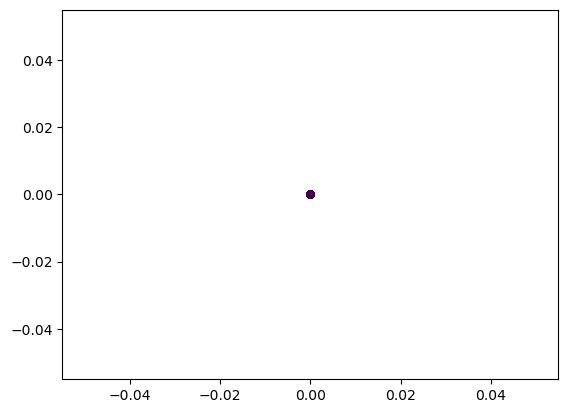

In [23]:
grid_view(f)

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. We use numpy for that.

In [24]:
# Geometry fix

t = f.samples
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

# define a regular IL and XL axis
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

# regular axis
ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))
print('# missing traces: {}'.format(np.sum(~traces_available)))

# reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# missing traces: 0


In [25]:
print(t.min(),t.max())

0.0 2000.0


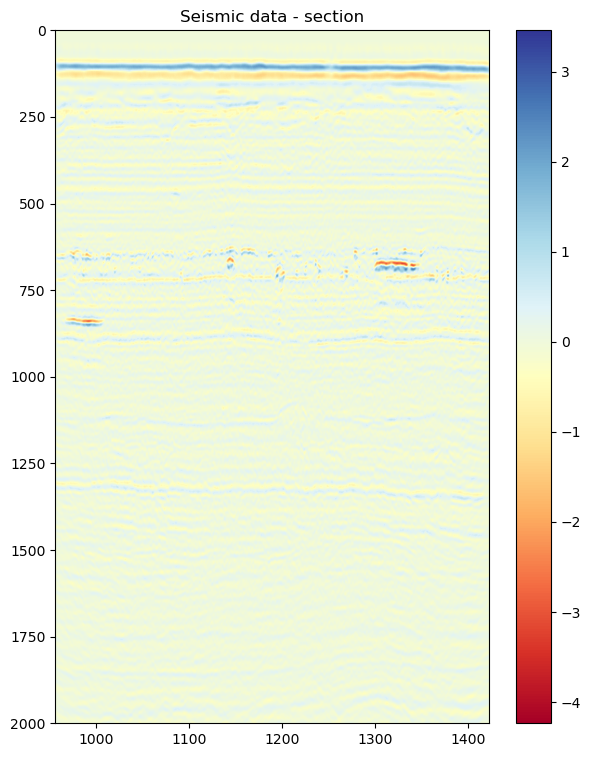

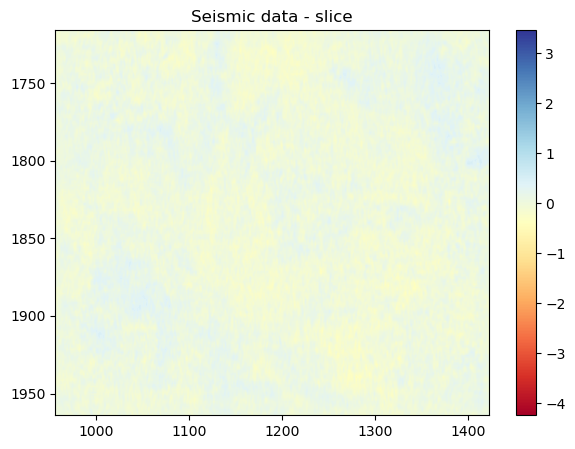

In [26]:
plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - section')
plt.colorbar()
plt.axis('tight');

plt.figure(figsize=(7, 5))
plt.imshow(d[..., nt//2], cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
plt.title('Seismic data - slice')
plt.colorbar()
plt.axis('tight');

Wavelet estimation and inverse

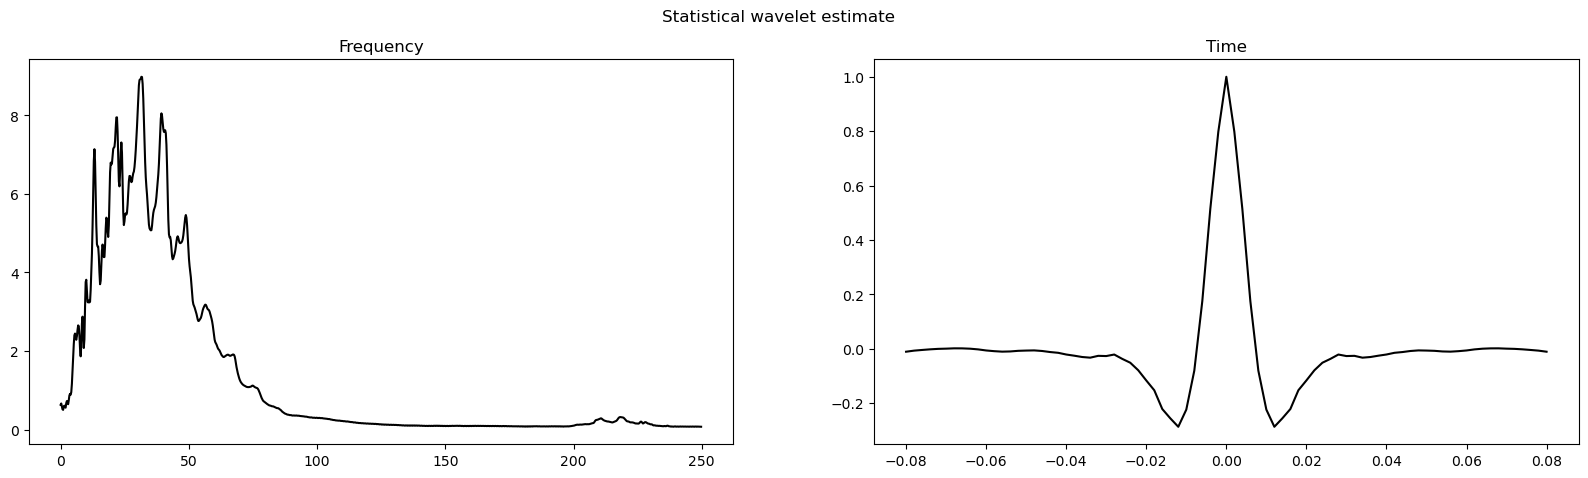

In [27]:
nt_wav = 41 # len of wavelet in samples
nfft = 2**11 # len of fft

# time axis for wavelet
t_wav = np.arange(nt_wav) * (dt/1000) 
t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# estimate wavelet spectrum
wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., 500:], nfft, axis=-1)), axis=(0, 1))
fwest = np.fft.fftfreq(nfft, d=dt/1000)

# create wavelet in time
wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
wav_est = wav_est / wav_est.max()
wcenter = np.argmax(np.abs(wav_est))

# display wavelet
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');

In [28]:
# swap time axis to first dimension
# itmin, itmax = t.min(),t.max()
# d_small = d[..., :]
# d_small = np.swapaxes(d_small, -1, 0)

# m_relative, r_relative = \
#     pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=np.zeros_like(d_small), explicit=True, 
#                                             epsI=1e-3, simultaneous=False)
# m_relative_reg, r_relative_reg = \
#     pylops.avo.poststack.PoststackInversion(d_small, wav_est, m0=m_relative, epsI=1e-4, epsR=5e1, 
#                                             **dict(iter_lim=20, show=2))
# # swap time axis back to last dimension
# d_small = np.swapaxes(d_small, 0, -1)
# m_relative = np.swapaxes(m_relative, 0, -1)
# m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
# r_relative = np.swapaxes(r_relative, 0, -1)
# r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

In [29]:
# ################################# FOR GPU ###############################
# import os
# import numpy as np
# import cupy as cp
# import scipy as sp
# import cusignal
# import matplotlib.pyplot as plt

# from scipy.signal import convolve, filtfilt

# from pylops.utils                      import dottest
# from pylops.utils.backend              import get_lstsq
# from pylops.utils.wavelets             import *
# from pylops.basicoperators             import *
# from pylops.avo.avo                    import *
# from pylops.avo.poststack              import *
# from pylops.avo.prestack               import *
# from pylops.optimization.basic         import *
# from pylops.optimization.leastsquares  import *
# dtype = np.float32



In [30]:
# swap time axis to first dimension
itmin, itmax = t.min(),t.max()
d_small = d[..., :]
d_small = np.swapaxes(d_small, -1, 0)


# CUPY CONVERSION for GPU
d_small_cp = cp.asarray(d_small.astype(dtype))
wav_est_cp = cp.asarray(wav_est.astype(dtype))
m0 = cp.zeros_like(d_small_cp, dtype=dtype)


# INVERSION
m_relative, r_relative = PoststackInversion(d_small_cp, wav_est_cp, m0=m0, explicit=True, epsI=1e-3,
                                            simultaneous=False, **dict(rcond=1e-5))

# Code below should not be executed!
# m_relative, r_relative = PoststackInversion(d_small_cp, wav_est_cp, m0=np.zeros_like(d_small_cp), explicit=False, 
#                                             epsR=0.1, **dict(show=True, niter=10, damp=1e-4))
# m_relative_reg, r_relative_reg = PoststackInversion(d_small_cp, wav_est_cp, m0=m_relative,
#                                                     epsR=np.sqrt(1e2), **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))
# del m_relative
# del r_relative
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()
# print(mempool.get_limit())  # 1073741824

In [31]:
# Optional memmory cleaning
# m_relative_cpu = cp.asnumpy(m_relative)
# r_relative_cpu = cp.asnumpy(r_relative)
# del m_relative
# del r_relative
# del PoststackInversion

In [32]:
# mempool.free_all_blocks()
# pinned_mempool.free_all_blocks()
# print(mempool.get_limit())

In [33]:
# Use asynchronous stream ordered memory
# cp.cuda.set_allocator(cp.cuda.MemoryAsyncPool().malloc)

# # Create a custom stream
# s = cp.cuda.Stream()

# # This would allocate memory asynchronously on stream s
# with s:
#     m_relative_reg, r_relative_reg = PoststackInversion(cp.asarray(d_small).astype(dtype), cp.asarray(wav_est).astype(dtype), m0=cp.asarray(d_small).astype(dtype),
#                                                       epsR=np.sqrt(1e2), 
#                                                       **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))
    
# m_relative_reg, r_relative_reg = PoststackInversion(d_small, wav_est, m0=d_small,
#                                                     epsR=np.sqrt(1e2), 
#                                                     **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))
# cp.get_default_memory_pool().free_all_blocks()
# cp.get_default_pinned_memory_pool().free_all_blocks()
# minv_lop_reg_f, dr_lop_reg_f = PoststackInversion(d_small_cp, wav_est_cp, m0=m_relative, explicit=False, 
#                                                   epsR=np.sqrt(1e2), 
#                                                   **dict(engine='pylops', damp=np.sqrt(1e-2), niter=50))

m_relative_reg = np.load("m_relative_reg.npy").astype(dtype)
r_relative_reg = np.load("r_relative_reg.npy").astype(dtype)


In [34]:
# swap time axis back to last dimension
d_small = np.swapaxes(d_small, 0, -1)
m_relative = np.swapaxes(m_relative, 0, -1)
m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
r_relative = np.swapaxes(r_relative, 0, -1)
r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)
# minv_lop_reg_f = np.swapaxes(minv_lop_reg_f, 0, -1)
# dr_lop_reg_f = np.swapaxes(dr_lop_reg_f, 0, -1)

In [35]:
m_relative_cpu = cp.asnumpy(m_relative)
r_relative_cpu = cp.asnumpy(r_relative)


In [36]:
#BACKING

# np.save("d_small.npy", d_small)
# np.save("m_relative.npy", m_relative_cpu)
# np.save("r_relative.npy", r_relative_cpu)
# np.save("wav_est.npy", wav_est)

We can now display the inverted model and residuals

In [37]:
t[-1]

2000.0

2000 0


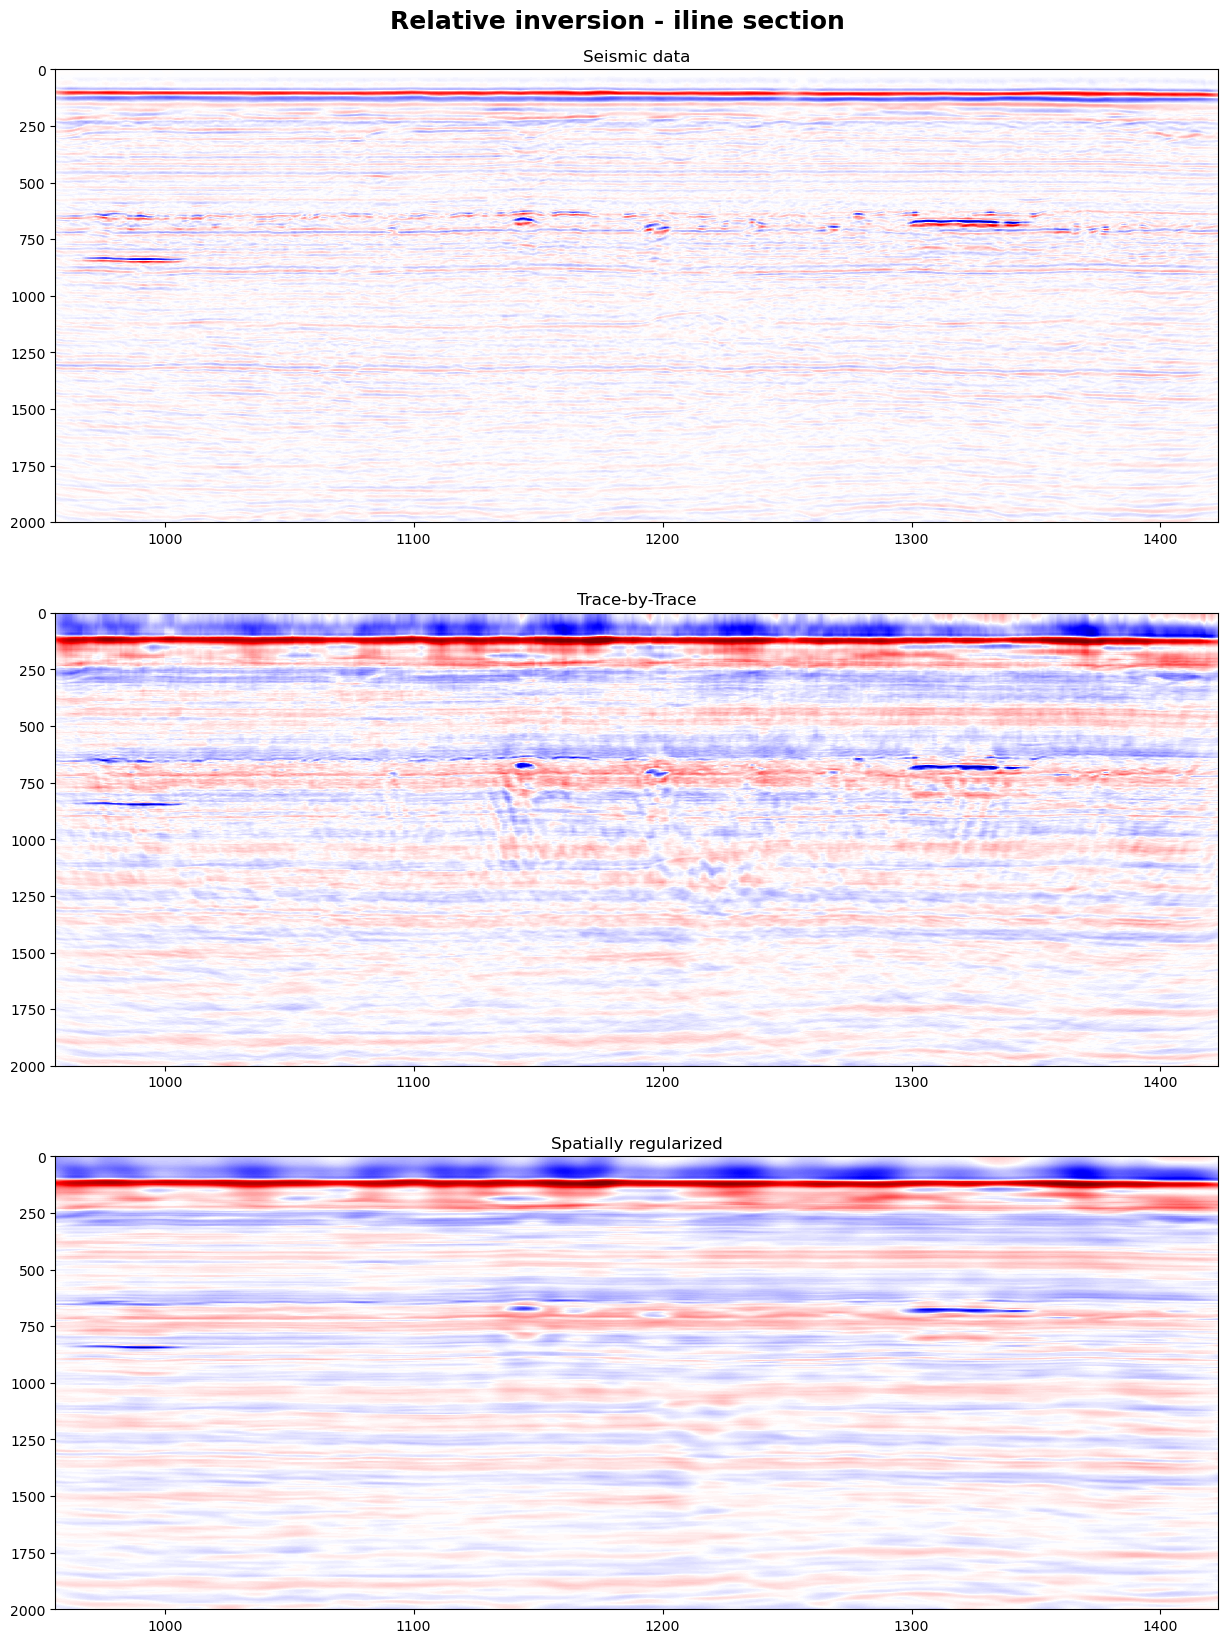

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
itmax, itmin = int(itmax), int(itmin)
print(itmax, itmin)
fig.suptitle('Relative inversion - iline section', y=0.91, fontweight='bold', fontsize=18)

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1],t[-1], t[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')

axs[1].imshow(m_relative_cpu[nil//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], t[-1], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')

axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1],t[-1], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

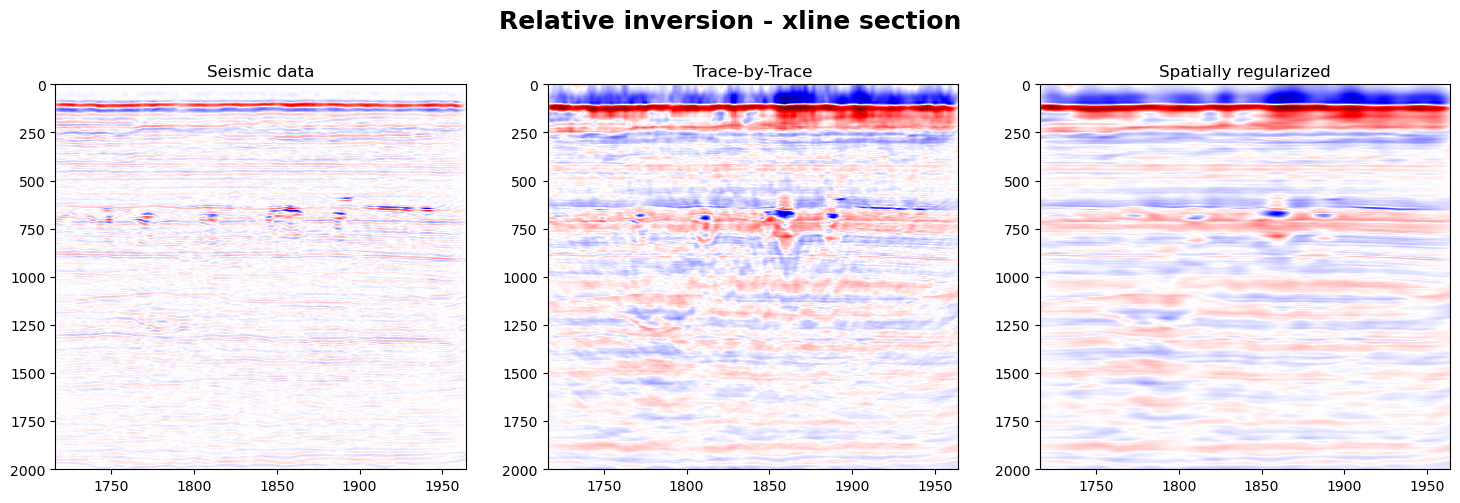

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Relative inversion - xline section', y=1.03, fontweight='bold', fontsize=18)


axs[0].imshow(d_small[:, nxl//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(il[0], il[-1], itmax, itmin))
axs[0].set_title('Seismic data')
axs[0].axis('tight')


axs[1].imshow(m_relative_cpu[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(il[0], il[-1], itmax, itmin))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')


axs[2].imshow(m_relative_reg[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(il[0], il[-1], itmax, itmin))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

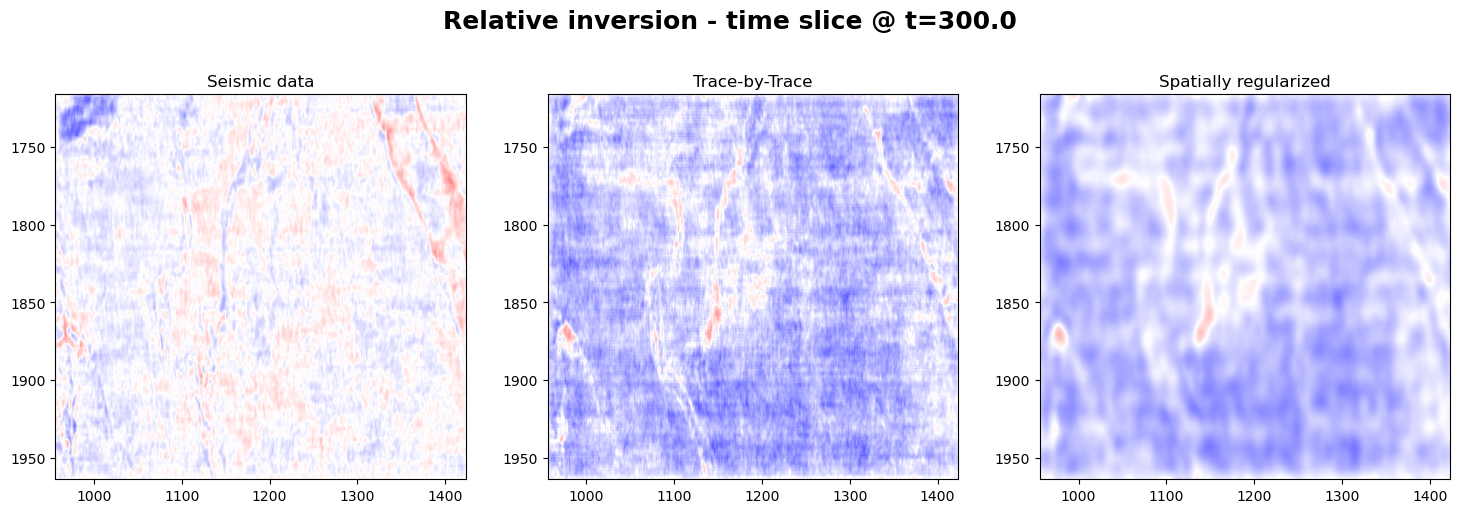

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

t_shift = 150 # Z SAMPLES SHIFT

fig.suptitle('Relative inversion - time slice @ t={}'.format(t[itmin+t_shift]), y=1.05, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[...,t_shift], cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_relative_cpu[...,t_shift], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
axs[2].imshow(m_relative_reg[...,t_shift], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

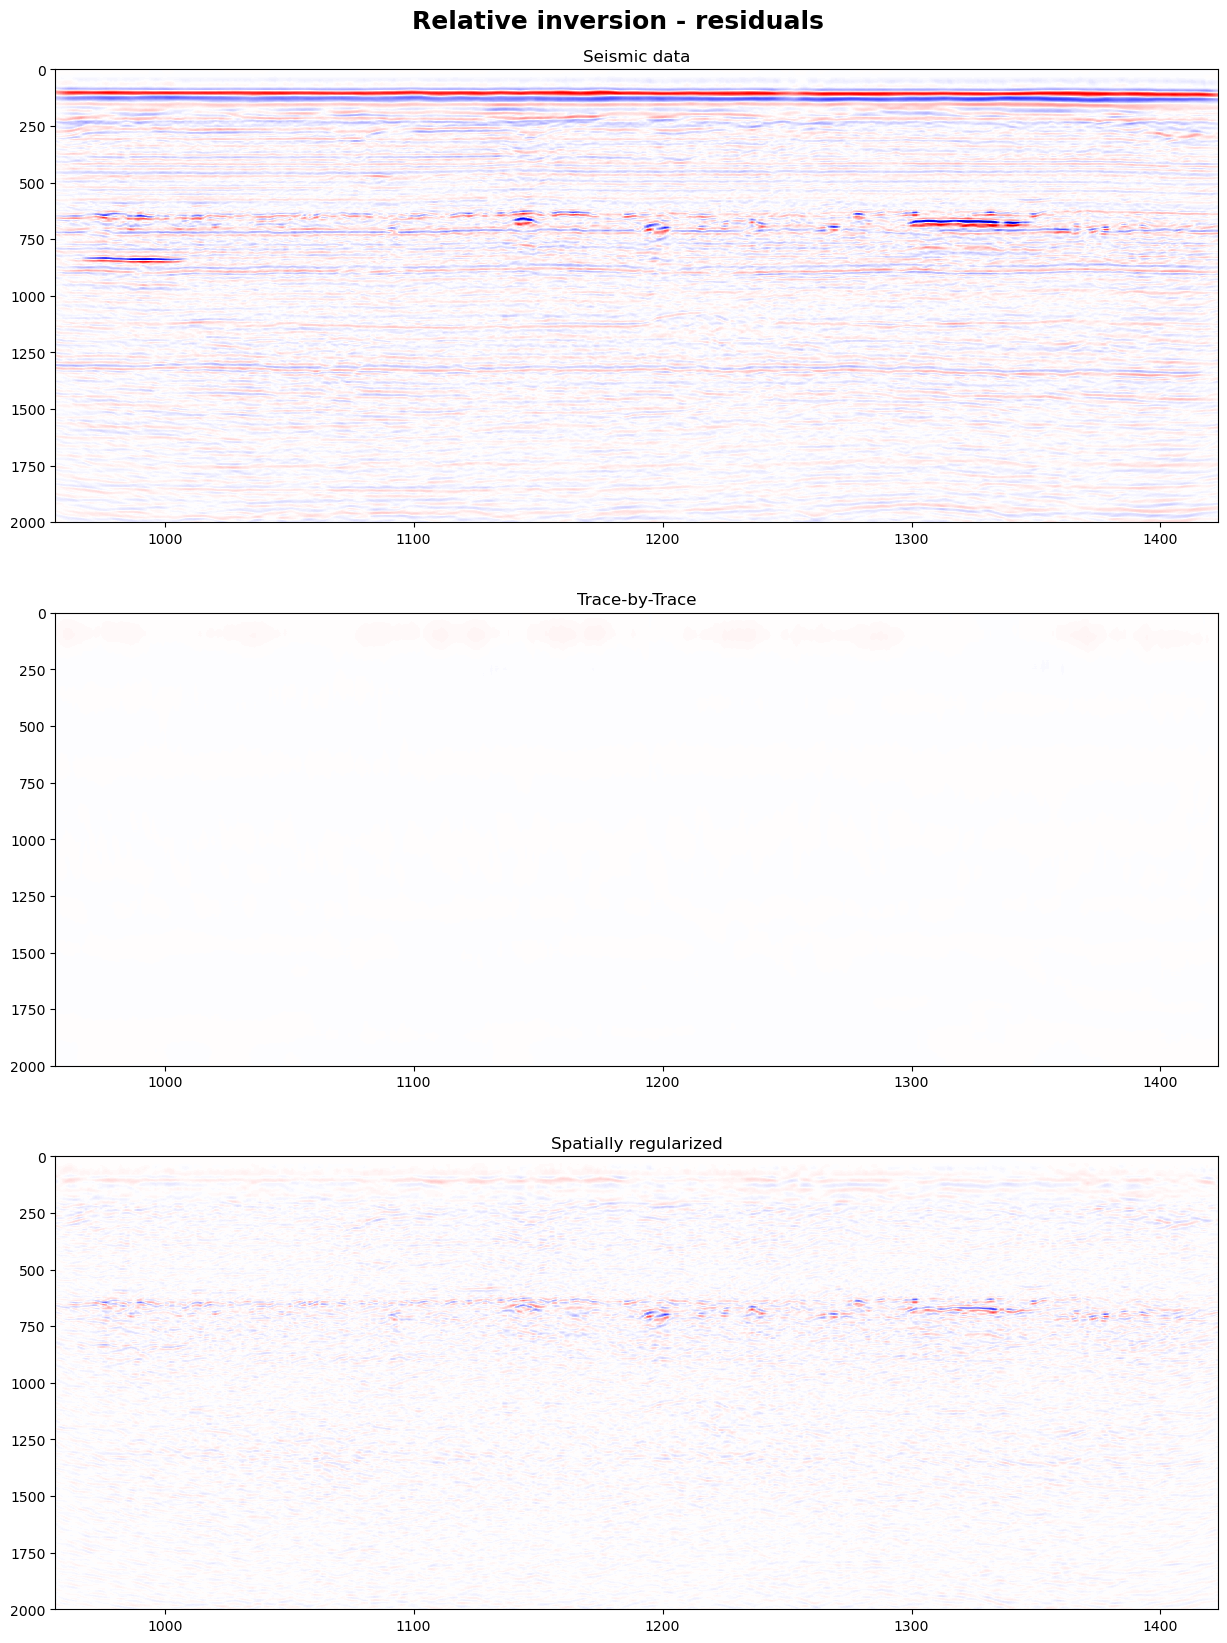

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Relative inversion - residuals', y=0.91, fontweight='bold', fontsize=18)

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], itmax, itmin))
axs[0].set_title('Seismic data')
axs[0].axis('tight')

axs[1].imshow(r_relative_cpu[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], itmax, itmin))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')

axs[2].imshow(r_relative_reg[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], itmax, itmin))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

### Write inverted cube back to a segy

Not regularized:

In [42]:
# Bring traces back to their original order and backuping
traces_to_save =  m_relative_cpu[ilgrid.ravel()[traces_available.ravel()],
                                 xlgrid.ravel()[traces_available.ravel()]]

np.save("backup_tts.npy", traces_to_save)

In [43]:
segyfile_inverted = './inverted.segy'

with segyio.open(segyfile, ignore_geometry=True) as source:
        spec = segyio.spec()
        spec.format = int(source.format)
        spec.samples = t[itmin:itmax]
        spec.tracecount = source.tracecount
        print("spec done...")
        with segyio.open(segyfile_inverted, "r+") as destination:
            # Code below is commented as I use copied file of original data for destination
            # Copy all textual headers, including possible extended
            # for i in range(source.ext_headers):
            #     destination.text[i] = source.text[i]

            # # Copy the binary header, then insert the modifications needed for the new time axis
            # destination.bin = source.bin
            # destination.bin = {segyio.BinField.Samples: itmax-itmin}
            
            # # Copy all trace headers to destination file
            # destination.header = source.header 

            # Copy data and modify trace header
            from tqdm.notebook import tqdm
            for itrace in tqdm(range(destination.tracecount)):
                destination.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin} 
                destination.trace[itrace] = traces_to_save[itrace].astype('float32')

spec done...


FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
# Bring traces back to their original order and backuping

traces_to_save_reg =  m_relative_reg[ilgrid.ravel()[traces_available.ravel()],
                                 xlgrid.ravel()[traces_available.ravel()]]

np.save("backup_tts_reg.npy", traces_to_save_reg)

Saving Regularized inversion traces:

In [ ]:
segyfile_inverted_reg = './inverted_reg.segy'
with segyio.open(segyfile, ignore_geometry=True) as source:
        spec = segyio.spec()
        spec.format = int(source.format)
        spec.samples = t[itmin:itmax]
        spec.tracecount = source.tracecount
        print("spec done...")
        with segyio.open(segyfile_inverted_reg, "r+") as destination:
            # Code below is commented as I use copied file of original data for destination
            # Copy all textual headers, including possible extended
            # for i in range(source.ext_headers):
            #     destination.text[i] = source.text[i]

            # # Copy the binary header, then insert the modifications needed for the new time axis
            # destination.bin = source.bin
            # destination.bin = {segyio.BinField.Samples: itmax-itmin}
            
            # # Copy all trace headers to destination file
            # destination.header = source.header 

            # Copy data and modify trace header
            from tqdm.notebook import tqdm
            for itrace in tqdm(range(destination.tracecount)):
                destination.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin} 
                destination.trace[itrace] = traces_to_save_reg[itrace].astype('float32')

spec done...


  0%|          | 0/116532 [00:00<?, ?it/s]

Read the file back to check if saving was successful

In [ ]:
f1 = segyio.open(segyfile_inverted, ignore_geometry=True)
traces1 = segyio.collect(f1.trace)[:]

np.allclose(traces1, traces_to_save)
#Return True if writing was successful

True